In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score

NUM_CLASSES = 12
RESULTS_BASE_DIR = "C:/Users/results/{}_classes/".format(NUM_CLASSES)

def read_classification_results(classification_results_dir):
    classification_results_path = os.path.join(classification_results_dir, "predictions", "classification_metrics.csv")
    if (os.path.exists(classification_results_path)):
        classification_data = np.genfromtxt(classification_results_path, delimiter=',', skip_header = 1)
        return classification_data
    return None


def get_classification_results_per_seq_aggr_method(seq_aggr_method_dir):
    result_list = []
    seg_aggr_method = os.path.basename(seq_aggr_method_dir)
    root_result_dirs = [seq_aggr_method_dir]
    if seg_aggr_method == "sampling":
        root_result_dirs = [os.path.join(seq_aggr_method_dir, sampling_result_dir) for sampling_result_dir in os.listdir(seq_aggr_method_dir)]
    
    for root_result_dir in root_result_dirs:
        pos_enc_dirs = [os.path.join(root_result_dir, pos_enc_method) for pos_enc_method in os.listdir(root_result_dir)]
        for pos_enc_opt_dir in pos_enc_dirs:
            pos_enc_opt = os.path.basename(pos_enc_opt_dir)
            for model_config in os.listdir(pos_enc_opt_dir):
                model_result_dir = os.path.join(pos_enc_opt_dir, model_config)
                classification_results = read_classification_results(model_result_dir)
                if classification_results is not None:
                    model_hyperparameters = model_config.split(",")
                    num_layers = model_hyperparameters[0].split("=")[1]
                    num_heads = model_hyperparameters[1].split("=")[1]
                    emb_dim = model_hyperparameters[2].split("=")[1]
                    result_list.append((
                        seg_aggr_method,
                        pos_enc_opt,
                        num_layers,
                        num_heads,
                        emb_dim,
                        classification_results[1],
                        classification_results[2],
                        classification_results[6]))
    
    result_df = pd.DataFrame(result_list, 
                        columns=["SEQ_AGGR", "POS_ENC", "NUM_LAYERS", "NUM_HEADS", "EMB_DIM", "ACCURACY", "AVERAGE_CLASS_ACCURACY", "F1_SCORE"])
    result_df.sort_values(by=["F1_SCORE", "AVERAGE_CLASS_ACCURACY"], inplace=True, ascending=False)    
    return result_df


def get_parcel_region_mapping(
    root_parcel_mapping_dir = "C:/Users/Ivica Obadic/Desktop/Explainable Machine Learning in Earth Observations/Projects/EO_explainability_survey/Datasets/BavarianCrops/ids/blocks"):
    parcel_region_mapping = []
    parcel_mapping_files = [("holl", os.path.join(root_parcel_mapping_dir, "holl_test.txt")),
                            ("nowa", os.path.join(root_parcel_mapping_dir, "nowa_test.txt")),
                            ("krum", os.path.join(root_parcel_mapping_dir, "krum_test.txt"))]
    
    for region, parcel_mapping_file in parcel_mapping_files:
            with open(parcel_mapping_file, 'r') as parcel_mapping:
                parcels_for_region = [(region, int(parcel_id.strip())) for parcel_id in parcel_mapping.readlines()]
                parcel_region_mapping.extend(parcels_for_region)
    
    parcel_region_mapping_df = pd.DataFrame(parcel_region_mapping, columns = ["REGION", "PARCEL_ID"])
    return parcel_region_mapping_df

def calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method):
    
    def calc_accuracy_per_region(df_region):
        accuracy = accuracy_score(df_region["LABEL"], df_region["PREDICTION"])
        f1 = f1_score(df_region["LABEL"], df_region["PREDICTION"], average="macro", zero_division=0)
        kappa = cohen_kappa_score(df_region["LABEL"], df_region["PREDICTION"])
        return pd.Series({'F1 SCORE': f1, 'AGGREGATION_METHOD': aggregation_method})
        #return pd.Series({'ACCURACY': accuracy, 'F1_SCORE': f1, 'KAPPA_SCORE': kappa, 'MODEL': aggregation_method})
    
    predictions_file = os.path.join(model_root_path, aggregation_method, "predictions", "predicted_vs_true.csv")
    predictions = pd.read_csv(predictions_file)
    predictions_with_region = pd.merge(parcel_region_mapping, predictions, on="PARCEL_ID")
    predictions_with_region = predictions_with_region.groupby("REGION").apply(calc_accuracy_per_region).reset_index()
    return predictions_with_region


def seq_aggr_strategy_comparison_plot(results_padding, results_weekly_average, results_sampling):
    all_results = pd.concat([results_padding, results_weekly_average, results_sampling])
    all_results = pd.melt(all_results, id_vars=['SEQ_AGGR'], value_vars=['AVERAGE_CLASS_ACCURACY', 'F1_SCORE'], var_name="METRIC", value_name="SCORE")
    fig, axs = plt.subplots(figsize=(10, 6))
    boxplot = sns.boxplot(x="SEQ_AGGR", y="SCORE",
            hue="METRIC", palette=["m", "g"],
            data=all_results, ax = axs)
    boxplot.set_title("Classification Results per Sequence Aggregation Strategies")
    
def seq_aggr_pos_enc_strategy_comparison_plot(results_padding, results_weekly_average, results_sampling):
    all_results = pd.concat([results_padding, results_weekly_average, results_sampling])
    all_results.sort_values(by=["F1_SCORE", "AVERAGE_CLASS_ACCURACY"], inplace=True, ascending=False)
    print(all_results)
    all_results = pd.melt(all_results, id_vars=['SEQ_AGGR', "POS_ENC"], value_vars=['AVERAGE_CLASS_ACCURACY'], var_name="METRIC", value_name="SCORE")
    fig, axs = plt.subplots(figsize=(10, 6))
    boxplot = sns.boxplot(x="SEQ_AGGR", y="SCORE",
            hue="POS_ENC", palette=["m", "g"],
            data=all_results, ax = axs)
    boxplot.set_title("Classification Results per Positional Encoding methods")


def hyperparams_partial_dependence_plot(results_table):
    
    seq_aggr_strategy = results_table["SEQ_AGGR"].values[0]
    avg_result_num_layers = results_table.groupby(["NUM_LAYERS"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_num_heads = results_table.groupby(["NUM_HEADS"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_emb_dim = results_table.groupby(["EMB_DIM"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_emb_dim = avg_result_emb_dim.sort_index()
    print(avg_result_emb_dim)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)
    num_layers_dependence_plot = sns.lineplot(data=avg_result_num_layers, ax = axs[0])
    num_heads_dependence_plot = sns.lineplot(data=avg_result_num_heads, ax = axs[1])
    emb_dim_dependence_plot = sns.lineplot(data=avg_result_emb_dim, ax = axs[2])
    fig.suptitle("Partial Dependence results for the {} sequence aggregation strategy".format(seq_aggr_strategy))

         SEQ_AGGR      POS_ENC NUM_LAYERS NUM_HEADS EMB_DIM  ACCURACY  \
8   right_padding  obs_aq_date          2         2     128  0.919118   
0   right_padding  obs_aq_date          1         1     128  0.916705   
24  right_padding    seq_order          1         1     128  0.915211   
12  right_padding  obs_aq_date          3         1     128  0.916073   
6   right_padding  obs_aq_date          2         1     128  0.917624   
42  right_padding    seq_order          4         1     128  0.911650   
40  right_padding    seq_order          3         4     128  0.912339   
32  right_padding    seq_order          2         2     128  0.910099   
14  right_padding  obs_aq_date          3         2     128  0.913718   
46  right_padding    seq_order          4         4     128  0.912626   
41  right_padding    seq_order          3         4      64  0.902516   
5   right_padding  obs_aq_date          1         4      64  0.912626   
1   right_padding  obs_aq_date          1         1

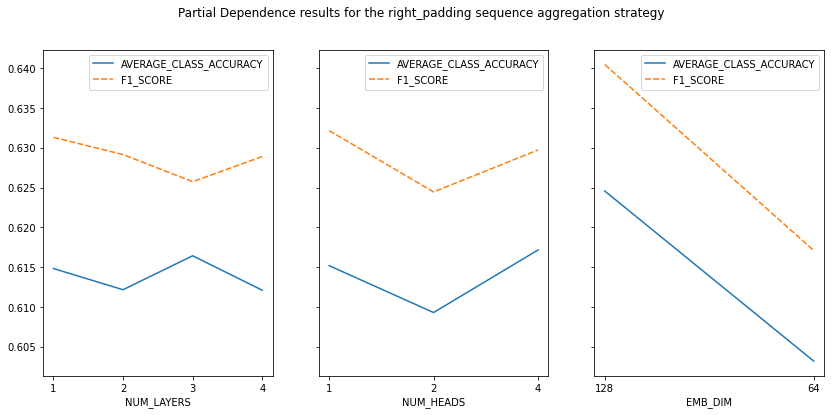

In [4]:
seq_aggr_method = "right_padding"
results_path = os.path.join(RESULTS_BASE_DIR, seq_aggr_method)
right_padding_results = get_classification_results_per_seq_aggr_method(results_path)
print(right_padding_results)
hyperparams_partial_dependence_plot(right_padding_results)

         AVERAGE_CLASS_ACCURACY  F1_SCORE
EMB_DIM                                  
128                    0.553834  0.567622
64                     0.546240  0.559124


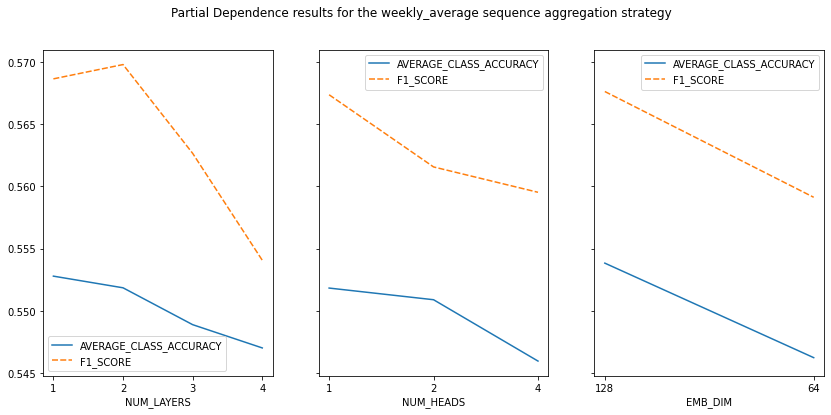

In [5]:
seq_aggr_method = "weekly_average"
results_path = os.path.join(RESULTS_BASE_DIR, seq_aggr_method)
weekly_average_results = get_classification_results_per_seq_aggr_method(results_path)
weekly_average_results
hyperparams_partial_dependence_plot(weekly_average_results)

     SEQ_AGGR      POS_ENC NUM_LAYERS NUM_HEADS EMB_DIM  ACCURACY  \
154  sampling  obs_aq_date          4         1     128  0.913603   
111  sampling    seq_order          2         4     128  0.906193   
82   sampling  obs_aq_date          2         2      64  0.910443   
91   sampling    seq_order          2         2     128  0.909180   
10   sampling    seq_order          1         1     128  0.907744   
..        ...          ...        ...       ...     ...       ...   
212  sampling    seq_order          3         1      64  0.893440   
2    sampling    seq_order          1         1      64  0.890108   
128  sampling    seq_order          3         1     128  0.890797   
230  sampling    seq_order          3         2      64  0.890510   
195  sampling    seq_order          4         4      64  0.883961   

     AVERAGE_CLASS_ACCURACY  F1_SCORE  
154                0.683261  0.687682  
111                0.643209  0.667677  
82                 0.653844  0.659518  
91         

SEQ_AGGR      POS_ENC NUM_LAYERS NUM_HEADS EMB_DIM  ACCURACY            \
                                                            mean       var   
8   sampling  obs_aq_date          2         2      64  0.906124  0.000016   
3   sampling  obs_aq_date          1         4     128  0.907169  0.000017   
9   sampling  obs_aq_date          2         4     128  0.906514  0.000010   
5   sampling  obs_aq_date          2         1     128  0.906905  0.000006   
11  sampling  obs_aq_date          3         1     128  0.907351  0.000004   
15  sampling  obs_aq_date          3         4     128  0.905044  0.000004   
13  sampling  obs_aq_date          3         2     128  0.905205  0.000025   
2   sampling  obs_aq_date          1         2     128  0.907820  0.000032   
0   sampling  obs_aq_date          1         1     128  0.909036  0.000003   
4   sampling  obs_aq_date          1         4      64  0.905457  0.000017   
10  sampling  obs_aq_date          2         4      64  0.902815  0.000043   
28  sampling    seq_order          2         1     128  0.901683  0.000005   
17  sampling  obs_aq_date          4         1     128  0.904573  0.000038   
21  sampling  obs_aq_date          4         4     128  0.904687  0.000016   
36  sampling    seq_order          3         2     128  0.902355  0.000009   
12  sampling  obs_aq_date          3         1      64  0.901832  0.000024   
40  sampling    seq_order          4         1     128  0.902700  0.000006   
7   sampling  obs_aq_date          2         2     128  0.904848  0.000011   
19  sampling  obs_aq_date          4         2     128  0.902792  0.000013   
32  sampling    seq_order          2         4     128  0.899954  0.000034   
30  sampling    seq_order          2         2     128  0.901792  0.000025   
22  sampling  obs_aq_date          4         4      64  0.901091  0.000007   
16  sampling  obs_aq_date          3         4      64  0.900942  0.000029   
6   sampling  obs_aq_date          2         1      64  0.902574  0.000026   
25  sampling    seq_order          1         2     128  0.902746       NaN   
26  sampling    seq_order          1         4     128  0.903102  0.000015   
38  sampling    seq_order          3         4     128  0.899380  0.000008   
14  sampling  obs_aq_date          3         2      64  0.900011  0.000007   
42  sampling    seq_order          4         2     128  0.899759  0.000010   
29  sampling    seq_order          2         1      64  0.900643  0.000017   
23  sampling    seq_order          1         1     128  0.902298  0.000014   
44  sampling    seq_order          4         4     128  0.900643  0.000009   
20  sampling  obs_aq_date          4         2      64  0.900402  0.000024   
34  sampling    seq_order          3         1     128  0.901448  0.000022   
1   sampling  obs_aq_date          1         1      64  0.903297  0.000002   
37  sampling    seq_order          3         2      64  0.898501  0.000017   
31  sampling    seq_order          2         2      64  0.898438  0.000008   
27  sampling    seq_order          1         4      64  0.897300  0.000019   
35  sampling    seq_order          3         1      64  0.896864  0.000020   
39  sampling    seq_order          3         4      64  0.897461  0.000022   
41  sampling    seq_order          4         1      64  0.897645  0.000017   
33  sampling    seq_order          2         4      64  0.896978  0.000006   
18  sampling  obs_aq_date          4         1      64  0.898840  0.000015   
43  sampling    seq_order          4         2      64  0.896737  0.000008   
24  sampling    seq_order          1         1      64  0.896243  0.000030   
45  sampling    seq_order          4         4      64  0.893569  0.000078   

   AVERAGE_CLASS_ACCURACY            F1_SCORE            
                     mean       var      mean       var  
8                0.628122  0.000276  0.640190  0.000274  
3                0.618160  0.000206  0.640032  0.000221  
9                0.617877  

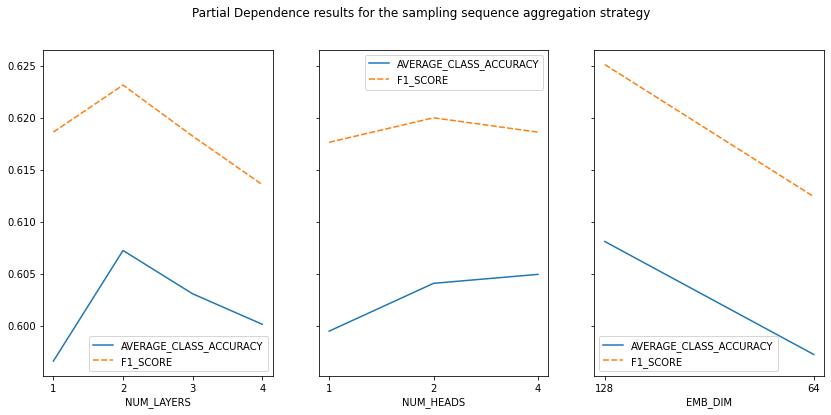

In [14]:
seq_aggr_method = "sampling"
results_path = os.path.join(RESULTS_BASE_DIR, seq_aggr_method)
random_sampling_results = get_classification_results_per_seq_aggr_method(results_path)
print(random_sampling_results)
hyperparams_partial_dependence_plot(random_sampling_results)
averaged_sampling_results = random_sampling_results.groupby(["SEQ_AGGR", "POS_ENC", "NUM_LAYERS", "NUM_HEADS", "EMB_DIM"]).agg(["mean", "var"]).reset_index()
averaged_sampling_results.sort_values(by=[("F1_SCORE", "mean"), ("AVERAGE_CLASS_ACCURACY", "mean")], inplace=True, ascending=False)
averaged_sampling_results

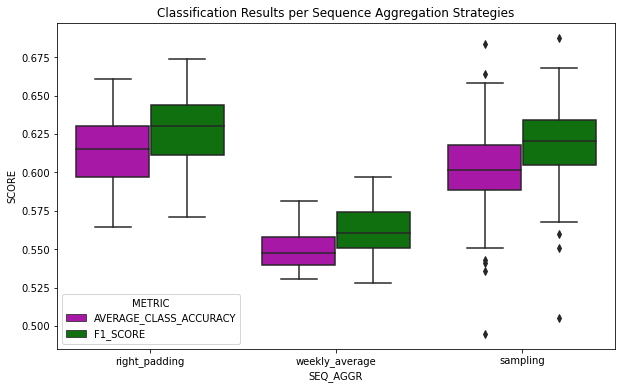

In [7]:
seq_aggr_strategy_comparison_plot(right_padding_results, weekly_average_results, random_sampling_results)

           SEQ_AGGR      POS_ENC NUM_LAYERS NUM_HEADS EMB_DIM  ACCURACY  \
154        sampling  obs_aq_date          4         1     128  0.913603   
8     right_padding  obs_aq_date          2         2     128  0.919118   
0     right_padding  obs_aq_date          1         1     128  0.916705   
111        sampling    seq_order          2         4     128  0.906193   
24    right_padding    seq_order          1         1     128  0.915211   
..              ...          ...        ...       ...     ...       ...   
16   weekly_average  obs_aq_date          4         1      64  0.884651   
1    weekly_average  obs_aq_date          1         1      64  0.895163   
14   weekly_average  obs_aq_date          3         4      64  0.888385   
17   weekly_average  obs_aq_date          4         2     128  0.883215   
195        sampling    seq_order          4         4      64  0.883961   

     AVERAGE_CLASS_ACCURACY  F1_SCORE  
154                0.683261  0.687682  
8                  

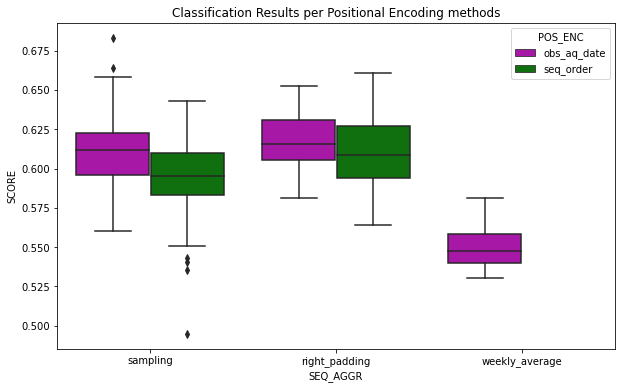

In [11]:
seq_aggr_pos_enc_strategy_comparison_plot(right_padding_results, weekly_average_results, random_sampling_results)

<ipython-input-28-dabc815aad54>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


                      0
TRUE_CLASS             
fallow              581
grassland         10878
winter wheat        995
corn               1917
summer wheat         56
winter spelt         52
winter rye          104
winter barley       777
summer barley      1017
summer oat          275
winter triticale    499
rapeseed            257


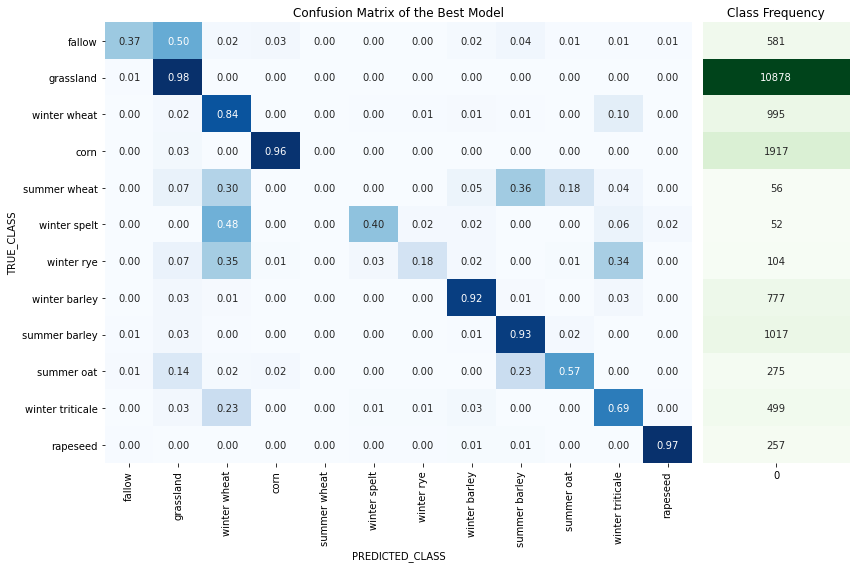

In [28]:
#confusion matrix analysis
best_model_cm_path = os.path.join(RESULTS_BASE_DIR, "right_padding", "obs_aq_date", "layers=2,heads=2,emb_dim=128", "predictions", "confusion_matrix.csv")
cm = pd.read_csv(best_model_cm_path)
cm["TRUE_CLASS"] = list(cm.columns)
cm.set_index("TRUE_CLASS", inplace=True)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_frequency = pd.DataFrame(cm.sum(axis=1))
print(class_frequency)

fig, axs = plt.subplots(ncols=2, figsize=(12, 8), gridspec_kw={'width_ratios': [4, 1]})

cm_plot = sns.heatmap(cmn, annot=True, cmap="Blues", ax=axs[0], cbar=None, fmt='.2f')
cm_plot.set_xlabel("PREDICTED_CLASS")
cm_plot.set_title("Confusion Matrix of the Best Model")

class_frequency_plot = sns.heatmap(class_frequency, annot=True, ax=axs[1], cbar=None, cmap="Greens", fmt="d", yticklabels=False)
class_frequency_plot.set_title("Class Frequency")
class_frequency_plot.set_xlabel("")
class_frequency_plot.set_ylabel("")
fig.tight_layout()